# The outflow of telecommunications company's clients

The telecommunications operator wants to learn how to predict customer churn. If it is discovered that a user is planning to leave, they will be offered promotional codes and special conditions. The operator's team has collected personal data about certain clients, as well as information about their tariffs and contracts.

## Services description

The operator provides two main types of services:

1. Landline telephone service. It is possible to connect the telephone to several lines at the same time.
2. The Internet. The connection can be of two types: via a telephone line or a fiber-optic cable.

The following services are also available:

- Internet security: antivirus and blocking of unsafe sites;
- Dedicated technical support line;
- Cloud file storage for data backup;
- Streaming TV and movie catalog.

Customers can pay for services every month or sign a contract for 1-2 years. Various payment methods and the possibility of receiving an electronic receipt are available.

## Loading libraries and data

In [1]:
!pip install phik

In [2]:
!pip install -U sklearn

In [3]:
!pip install catboost

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier

RANDOM_STATE = 150523

In [5]:
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [6]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Let's combine all the tables into one through the 'CustomerID' column

In [10]:
df = df_contract.merge(df_personal, how='outer', on='customerID')\
    .merge(df_internet, how='outer', on='customerID')\
    .merge(df_phone, how='outer', on='customerID')
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [11]:
df_contract.shape, df_personal.shape, df_internet.shape, df_phone.shape, df.shape

((7043, 8), (7043, 5), (5517, 8), (6361, 2), (7043, 20))

Let's check for duplicates and omissions.

In [12]:
df.duplicated().sum()

0

In [13]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


There are no duplicates, but there are gaps in the columns with the object data type, we will replace them with the abbreviation No, because most likely customers simply do not use these services, also the "TotalCharges" column has an incorrect data type and implicit gaps.

In [15]:
df = df.fillna('No')

In [16]:
df[df['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,No,No,No,No,No,No,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,No,No,No,No,No,No,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


We have data for 2020-02-01, and for customers with missing values in Total Charges, this is the start date of using the services, let's fill in TotalCharges with data from MonthlyCharges.

In [17]:
def fill_gap(row):
    if row['TotalCharges'] == ' ':
        return row['MonthlyCharges']
    else:
        return row['TotalCharges']

In [18]:
df['TotalCharges'] = df.apply(fill_gap, axis=1)
df['TotalCharges'] = df['TotalCharges'].astype('float64')

In [19]:
df[df['BeginDate'] == '2020-02-01'].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25,Male,0,No,Yes,No,No,No,No,No,No,No,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No


In [20]:
df.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.377573,0.162147
std,30.090047,2112.678861,0.368612
min,18.250000,19.050000,0.000000
25%,35.500000,436.750000,0.000000
50%,70.350000,1343.350000,0.000000
75%,89.850000,3236.690000,0.000000
max,118.750000,9221.380000,1.000000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


Most of the signs are categorical, except for MonthlyCharges and TotalCharges. The SeniorCitizen attribute is also categorical and already has numerical coding, we will take this into account when creating the Pipeline.

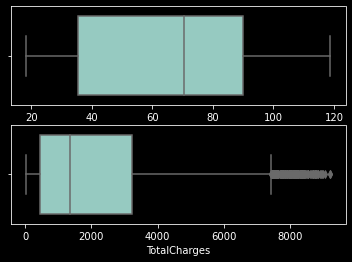

In [22]:
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(2, 1)
sns.boxplot(x=df['MonthlyCharges'], ax=ax1)
sns.boxplot(x=df['TotalCharges'], ax=ax2);

In [23]:
df[df['TotalCharges'] > 8000].sort_values('BeginDate')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
4610,2889-FPWRM,2013-10-01,No,One year,Yes,Bank transfer (automatic),117.80,9221.38,Male,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3040,7317-GGVPB,2013-11-01,No,Two year,Yes,Credit card (automatic),108.60,8145.00,Male,0,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
975,2834-JRTUA,2013-11-01,No,Two year,Yes,Electronic check,108.05,8184.79,Male,0,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes
3634,3258-SYSWS,2014-02-01,No,Two year,No,Bank transfer (automatic),113.80,8193.60,Male,1,No,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4553,5914-XRFQB,2014-02-01,No,Two year,Yes,Bank transfer (automatic),115.80,8504.35,Male,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,3766-EJLFL,2014-06-01,No,Two year,Yes,Bank transfer (automatic),109.05,8082.79,Female,0,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes
4838,1360-XFJMR,2014-07-01,No,One year,Yes,Credit card (automatic),109.70,8011.39,Female,0,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
2743,2323-ARSVR,2014-07-01,No,Two year,Yes,Electronic check,111.05,8035.58,Male,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,No
6451,4868-AADLV,2014-08-01,No,One year,Yes,Electronic check,116.25,8363.03,Male,1,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes


TotalCharges have outliers according to the boxplot version, but if you look at the date of user registration, you can understand that these are regular customers who have a long payment history and should not be deleted. We will add a column with a target attribute through a sign with the end date of using the services, and also add a feature with the number of days of the contract at the time of data upload.

In [24]:
df['target'] = df['EndDate'].apply(lambda x: 1 if x !='No' else 0)

In [25]:
def fill_date(value):
    if value == 'No':
        return '2020-02-01'
    else:
        return value

In [26]:
df['EndDate_new'] = df['EndDate'].apply(fill_date)

In [27]:
df['EndDate_new'] = df['EndDate_new'].astype('datetime64')
df['BeginDate'] = df['BeginDate'].astype('datetime64')
df['count_days'] = (df['EndDate_new'] - df['BeginDate']).dt.days

We will also add a feature with the number of days until the next payment and the num days from last payment. If the contract is no longer valid, then we count the number of days until the next payment from the end date of the contract.

In [28]:
def num_days_to_next_payment(row):
    next_date_payment = row['BeginDate']
    if row['Type'] == 'Month-to-month':
        while next_date_payment < row['EndDate_new']:
            next_date_payment = next_date_payment + pd.to_timedelta(30, unit='d')
        return (next_date_payment - row['EndDate_new']).days
    elif row['Type'] == 'One year':
        while next_date_payment < row['EndDate_new']:
            next_date_payment = next_date_payment + pd.to_timedelta(365, unit='d')
        return (next_date_payment - row['EndDate_new']).days
    else:
        while next_date_payment < row['EndDate_new']:
            next_date_payment = next_date_payment + pd.to_timedelta(730, unit='d')
        return (next_date_payment - row['EndDate_new']).days

In [29]:
df['num_days_to_next_payment'] = df.apply(num_days_to_next_payment, axis=1)

In [30]:
def num_days_from_last_payment(row):
    last_date_payment = row['BeginDate']
    if row['Type'] == 'Month-to-month':
        while last_date_payment < row['EndDate_new']:
            last_date_payment = last_date_payment + pd.to_timedelta(30, unit='d')
        return (row['EndDate_new'] - (last_date_payment - pd.to_timedelta(30, unit='d'))).days
    elif row['Type'] == 'One year':
        while last_date_payment < row['EndDate_new']:
            last_date_payment = last_date_payment + pd.to_timedelta(365, unit='d')
        return (row['EndDate_new']- (last_date_payment - pd.to_timedelta(365, unit='d'))).days
    else:
        while last_date_payment < row['EndDate_new']:
            last_date_payment = last_date_payment + pd.to_timedelta(730, unit='d')
        return (row['EndDate_new']- (last_date_payment - pd.to_timedelta(730, unit='d'))).days

In [31]:
df['num_days_from_last_payment'] = df.apply(num_days_from_last_payment, axis=1)

In [32]:
df[['BeginDate', 'Type', 'num_days_to_next_payment', 'num_days_from_last_payment', 'EndDate_new']].head()

,BeginDate,Type,num_days_to_next_payment,num_days_from_last_payment,EndDate_new
0,2020-01-01,Month-to-month,29,1,2020-02-01
1,2017-04-01,One year,59,306,2020-02-01
2,2019-10-01,Month-to-month,27,3,2020-02-01
3,2016-05-01,One year,89,276,2020-02-01
4,2019-09-01,Month-to-month,27,3,2020-02-01


Remove unnecessary features

In [33]:
df = df.drop(['customerID', 'BeginDate', 'EndDate', 'EndDate_new'], axis=1)

Since we have a lot of categorical features, let's check the correlation between the features using phik.Since we have a lot of categorical features, let's check the correlation between the features using phik.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'target', 'count_days', 'num_days_to_next_payment', 'num_days_from_last_payment']


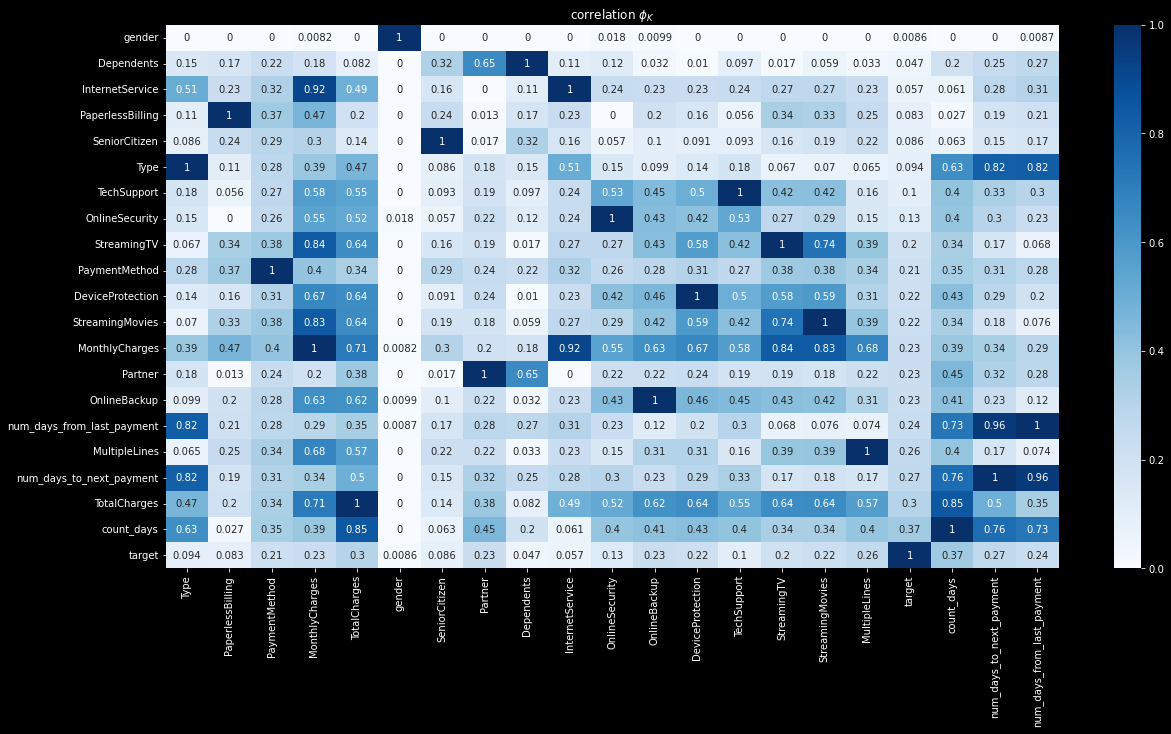

In [34]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.phik_matrix().sort_values(by='target'), cmap='Blues', annot=True)
plt.title('correlation $\phi_K$');

The graph shows that the target attribute has a very weak relationship with gender, Dependents. Let's remove these features.

In [35]:
df = df.drop(['gender', 'Dependents'], axis=1)

Let's look at the values in categorical features

In [36]:
for col in df.select_dtypes(include='object').columns:
    print(df[col].value_counts())
    print('-'*40)

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64
----------------------------------------
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64
----------------------------------------
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64
----------------------------------------
No     3641
Yes    3402
Name: Partner, dtype: int64
----------------------------------------
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
----------------------------------------
No     5024
Yes    2019
Name: OnlineSecurity, dtype: int64
----------------------------------------
No     4614
Yes    2429
Name: OnlineBackup, dtype: int64
----------------------------------------
No     4621
Yes    2422
Name: DeviceProtection, dtype: int64
----------------------------------------
No     4999
Yes    204

Let's check the distribution of the target feature.

In [37]:
df['target'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: target, dtype: float64

In [38]:
df.select_dtypes(exclude='object').columns

Index(['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'target',
       'count_days', 'num_days_to_next_payment', 'num_days_from_last_payment'],
      dtype='object')

In [39]:
df['MonthlyCharges']

0        29.85
1        56.95
2        53.85
3        42.30
4        70.70
         ...  
7038     84.80
7039    103.20
7040     29.60
7041     74.40
7042    105.65
Name: MonthlyCharges, Length: 7043, dtype: float64

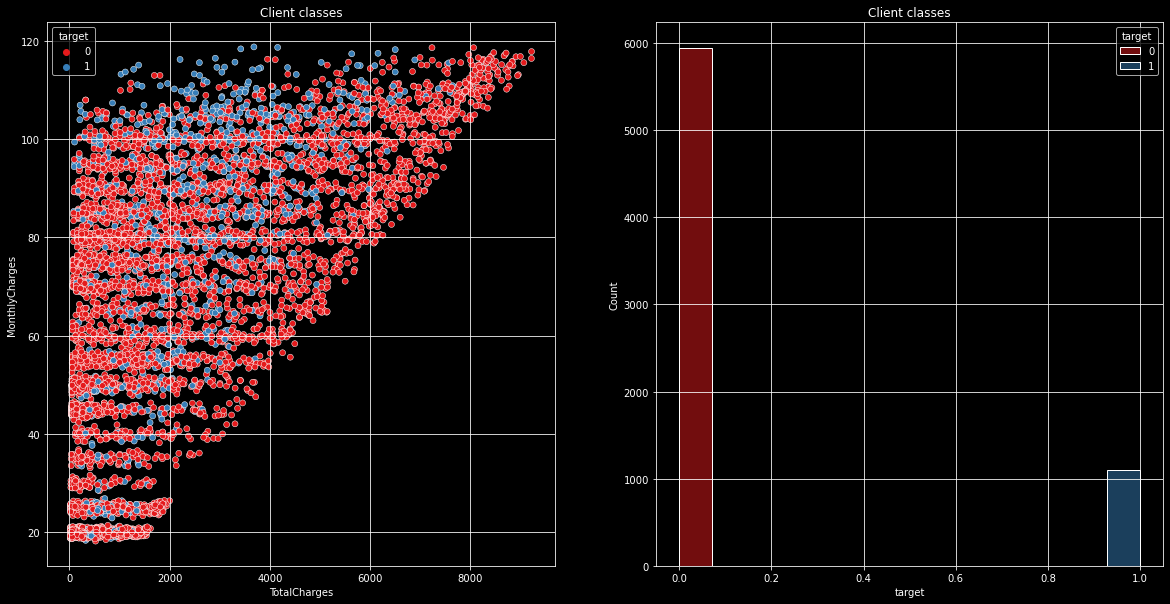

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.grid()
sns.set_palette("Set1")
sns.scatterplot(data=df, x='TotalCharges', y='MonthlyCharges', hue='target', ax=ax1)
ax1.set_xlabel('TotalCharges')
ax1.set_ylabel('MonthlyCharges')
ax1.set_title('Client classes')
ax2.grid()
sns.histplot(df, x='target', hue='target', ax=ax2)
ax2.set_title('Client classes');

As you can see, there is an imbalance of the target attribute in the data. Let's take this into account when building the model.

In [41]:
df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,count_days,num_days_to_next_payment,num_days_from_last_payment
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,Yes,DSL,No,Yes,No,No,No,No,No,0,31,29,1
1,One year,No,Mailed check,56.95,2071.84,0,No,DSL,Yes,No,Yes,No,No,No,No,0,1036,59,306
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,No,DSL,Yes,Yes,No,No,No,No,No,0,123,27,3
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371,89,276
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,No,Fiber optic,No,No,No,No,No,No,No,0,153,27,3


## Preprocessing

### Splitting into train and test samples

Let's split the sample into training and test in a ratio of 3 to 1 (test_size=0.25), using shuffle and stratify, because we have an imbalance of the target feature.

In [42]:
X = df.drop('target', axis=1)
y = df['target']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)

### Features transformation

Let's create lists with the names of categorical and quantitative features.

In [44]:
cat_features = X.select_dtypes(include='object').columns.to_list()
num_features = X.select_dtypes(exclude='object').columns.to_list()
num_features.remove('SeniorCitizen')

In [45]:
display(X[num_features].head()), display(X[cat_features].head())

,MonthlyCharges,TotalCharges,count_days,num_days_to_next_payment,num_days_from_last_payment
0,29.85,31.04,31,29,1
1,56.95,2071.84,1036,59,306
2,53.85,226.17,123,27,3
3,42.30,1960.60,1371,89,276
4,70.70,353.50,153,27,3


,Type,PaperlessBilling,PaymentMethod,Partner,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Month-to-month,Yes,Electronic check,Yes,DSL,No,Yes,No,No,No,No,No
1,One year,No,Mailed check,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),No,DSL,Yes,No,Yes,Yes,No,No,No
4,Month-to-month,Yes,Electronic check,No,Fiber optic,No,No,No,No,No,No,No


(None, None)

Let's build a Column Transformer with the following steps: StandardScaler for numerical features and OneHotEncoder with handle_unknown="ignore" for categorical features in case there are differences in feature values between the training and test sets. We'll add remainder="passthrough" to ensure that features not involved in encoding are not lost.

In [46]:
# make Pipeline with ColumnTransformer
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

## Building and training models

Although the ROC-AUC metric is resistant to imbalance, we will use class weighting in all models, because the Accuracy metric is more understandable for business, and it, in turn, is sensitive to imbalance.Although the ROC-AUC metric is resistant to imbalance, we will use class weighting in all models, because the Accuracy metric is more understandable for business, and it, in turn, is sensitive to imbalance.

### LogisticRegression

In [47]:
# creating copies of training samples to avoid changes in the main selections
X_train_lr = X_train.copy()
y_train_lr = y_train.copy()
# make Pipeline for LogisticRegression
pipline_lr = Pipeline(
    [('preprocessor', preprocessor),
     ('lr', LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE))])

Make GridSearchCV for LogisticRegression

In [48]:
param_lr = {'lr__C': np.logspace(-5, 5, 11), }
grid_lr = GridSearchCV(pipline_lr, param_grid=param_lr,
                       scoring='roc_auc', cv=4, n_jobs=-1)
grid_lr.fit(X_train_lr, y_train_lr)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'count_days',
                                                                          'num_days_to_next_payment',
                                                                          'num_days_from_last_payment']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [...
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'MultipleLines'])],
                                                          verbose_feature_names_out=False)),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=150523))]),
             n_jobs=-1,
             param_grid={'lr__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
             scoring='roc_auc')

Create dataframe with training results

In [49]:
best_result_lr = pd.DataFrame(
    grid_lr.cv_results_).sort_values('rank_test_score').head(1)
best_result_lr = best_result_lr[['mean_test_score']]
best_result_lr

,mean_test_score
6,0.75967


### SVC

In [50]:
# creating copies of training samples to avoid changes in the main selections
X_train_svc = X_train.copy()
y_train_svc = y_train.copy()
# make Pipeline for SVC
svc = Pipeline(
    [('preprocessor', preprocessor),
     ('svc', SVC(class_weight='balanced', random_state=RANDOM_STATE))]
)

Make GridSearchCV for SVC

In [51]:
params_svc = {'svc__C': [0.1, 1, 10, 100],
              'svc__gamma': [1, 0.1, 0.01, 0.001],
              'svc__kernel': ['rbf', 'poly', 'sigmoid']}
grid_svc = GridSearchCV(svc, param_grid=params_svc,
                        cv=4, scoring='roc_auc', n_jobs=-1)
grid_svc.fit(X_train_svc, y_train_svc)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'count_days',
                                                                          'num_days_to_next_payment',
                                                                          'num_days_from_last_payment']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [...
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'MultipleLines'])],
                                                          verbose_feature_names_out=False)),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            random_state=150523))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10, 100],
                         'svc__gamma': [1, 0.1, 0.01, 0.001],
                         'svc__kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='roc_auc')

Create dataframe with training results

In [52]:
best_result_svc = pd.DataFrame(
    grid_svc.cv_results_).sort_values('rank_test_score').head(1)
best_result_svc = best_result_svc[['mean_test_score']]
best_result_svc

,mean_test_score
30,0.822571


### CatBoostClassifier

Make GridSearchCV for CatBoostClassifier with own encoder

In [53]:
# creating copies of training samples to avoid changes in the main selections
X_train_cb = X_train.copy()
y_train_cb = y_train.copy()

params_cb = {'max_depth': [2, 3, 4, 5],
              'n_estimators': range(1000, 3001, 500),
              'learning_rate': [0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
              'l2_leaf_reg': [0.1, 0.3, 0.5, 0.7, 1, 2, 3, 4, 5, 6]}

cb = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false',
                         early_stopping_rounds=20,
                         cat_features=cat_features,
                         auto_class_weights='Balanced',
                         logging_level='Silent'
                        )

grid_search_result = cb.grid_search(param_grid=params_cb,
                                    X=X_train_cb,
                                    y=y_train_cb,
                                    cv=4,
                                    partition_random_seed=RANDOM_STATE,
                                    shuffle=True,
                                    stratified=True,
                                    refit=True,
                                    verbose=False,
                                    plot=True,
                                    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [54]:
best_result_cb = pd.DataFrame(grid_search_result['cv_results'])[['test-AUC-mean']].sort_values('test-AUC-mean', ascending=False).head(1)
best_result_cb = best_result_cb.rename(columns={'test-AUC-mean': 'mean_test_score'})
best_result_cb

,mean_test_score
116,0.878759


### Training results

Creating a common dataframe for all results with the best ROC_AUC values

In [55]:
result = pd.concat([best_result_lr, best_result_svc, best_result_cb])
result.index = ['LogisticRegression', 'SVC', 'CatBoostClassifier']

Determing the best model

In [56]:
result

,mean_test_score
LogisticRegression,0.759670
SVC,0.822571
CatBoostClassifier,0.878759


In [57]:
cb.get_params()

{'logging_level': 'Silent',
 'auto_class_weights': 'Balanced',
 'eval_metric': 'AUC:hints=skip_train~false',
 'early_stopping_rounds': 20,
 'cat_features': ['Type',
  'PaperlessBilling',
  'PaymentMethod',
  'Partner',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'MultipleLines'],
 'depth': 3,
 'iterations': 1000,
 'learning_rate': 0.4,
 'l2_leaf_reg': 0.5}

According to the results of training and validation, the best model was CatBoostClassifier{'depth': 3,
 'iterations': 1000,
 'learning_rate': 0.4,
 'l2_leaf_reg': 0.5} with its own encoding. Let's see which features most affected the training.

In [58]:
pd.DataFrame(cb.feature_importances_, index=cb.feature_names_).sort_values(0, ascending=False)

,0
count_days,35.465251
TotalCharges,16.573615
MonthlyCharges,12.309397
num_days_from_last_payment,12.096121
num_days_to_next_payment,10.069473
PaymentMethod,2.728714
Type,1.645319
Partner,1.398242
InternetService,1.228983
PaperlessBilling,1.041826


The training was most affected by how many days the contract lasts, and the total amount of payments made by the company's customers, additional services affected the result the least.

## Testing

Let's test the best model and check the score.

In [59]:
roc_auc_score(y_test, cb.predict_proba(X_test)[:, 1])

0.9221632203597211

We got a metric above 0.9. Plot the ROC-AUC graph

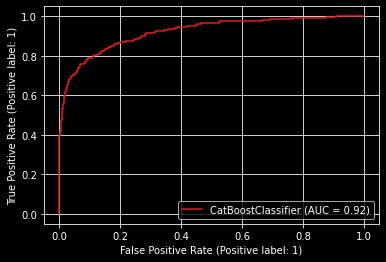

In [60]:
RocCurveDisplay.from_estimator(cb, X_test, y_test)
plt.grid();

Let's build confusion matrix and check determine each classes

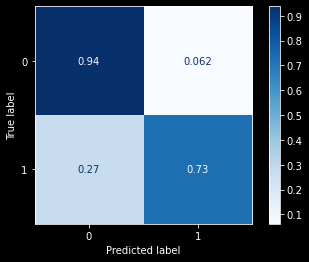

In [61]:
ConfusionMatrixDisplay.from_estimator(cb, X_test, y_test, normalize='true', cmap='Blues');

Since metric Accuracy is more understandable for business we'll use it for demonstration results.

In [62]:
accuracy_score(y_test, cb.predict(X_test))

0.9051675184554231

One test sample can't show how well our model works when receiving another sample. Using the bootstrap method, we can get a confidence interval that will reflect the real value of the accuracy score that will be included in it.

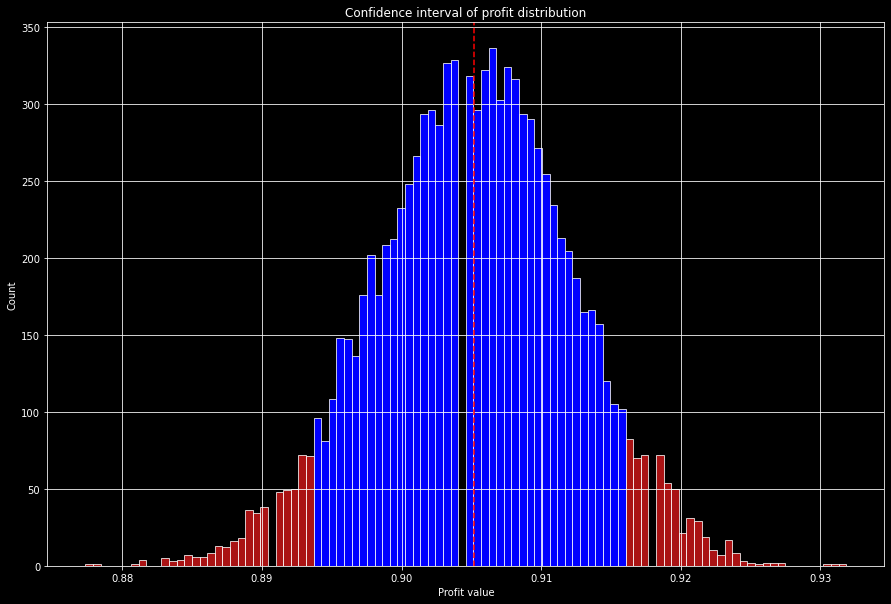

Average accuracy: 0.905
Confidence interval 0.891 0.919


In [63]:
y_pred = pd.Series(cb.predict(X_test), index=y_test.index)
accuracy = []
state = np.random.RandomState(RANDOM_STATE)
for i in range(10000):
    subsample = y_test.sample(n=len(y_test), replace=True, random_state=state)
    accuracy.append(accuracy_score(subsample, y_pred[subsample.index]))
    
accuracy=pd.Series(accuracy)
plt.figure(figsize=(15,10))
ax = sns.histplot(accuracy, kde=False, bins=100)
bars = ax.patches
for bar in bars:
    if bar.get_x() >= accuracy.quantile(0.05) and\
    bar.get_x() + bar.get_width() <= accuracy.quantile(0.95):
        bar.set_facecolor('b')
plt.axvline(accuracy.mean(), color='r', linestyle='--', label='Mean')
plt.title('Confidence interval of profit distribution')
plt.xlabel('Profit value')
plt.grid()
plt.show()
print('Average accuracy:', round(accuracy.mean(),3))
print('Confidence interval', round(accuracy.quantile(.025),3), round(accuracy.quantile(.975),3))

## Conclusion

We analyzed the data obtained, for this we connected all the downloaded files, checked the duplicates and filled in the gaps. After that, we created an additional attributes - the number of days of the contract, number days to next payment and number days from last payment and checked the relationship of the data. Some features had a very weak correlation with the target feature, so we got rid of them. During the analysis, an imbalance of the classes of the target feature was found, which was taken into account when splitting into a training and test sample, as well as in the process of training the model to maximize the Accuracy metric.
At the training stage, three LogisticRegression, SVC and CatBoostClassifier models were trained. According to the results of the training, the latter showed the best quality.
After testing the model on a test sample, we obtained a ROC-AUC value of 0.922, which satisfies the conditions of the problem. Additionally, we checked the model through the confusion matrix, where it is clear that the first class is determined with an accuracy of 73%, and the zero class is 94%, and the Accuracy metric, which showed an accuracy of 90.5%. Using bootstrap we got a confidence interval (0.891, 0.919), which includes real value of Accuracy score. Depending on the needs of the business, we can also vary the values of TP and TN by changing the threshold, thus affecting the costs and income of the company.